## Variance Reduction
We consider, within the Black & Scholes model, a discrete arithmetic Asian option with maturity T and strike K. Reference values can be taken as S0​=100, K=100, T=1, r=0.05, σ=0.20, d=12, N=105.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### 1. We plot, as a function of S0​ on the same graph, the exact price of the European call and the Monte Carlo price of the Asian option with the same strike and maturity at d dates.

We use the following formula to calculate the different terms of the Asian option: $$S_{t_i} = S_{t_{i-1}} \exp\left( (r - \frac{\sigma^2}{2})\Delta t + \sigma \sqrt{\Delta t} Z_i \right)$$


With Zi​ following a standard normal distribution.

Then we calculate the payoff:
$$\text{Payoff} = \left( \frac{1}{d} \sum_{i=1}^{d} S_{t_i} - K \right)_+$$

In [2]:
# Parameters
K = 100
T = 1.0
r = 0.05
sigma = 0.20
d = 12          # Number of observations (monthly)
N = 100000      # Number of simulations (10^5)

# Black-Scholes Formula (European Call)
def bs_call_price(S, K, T, r, sigma):
    """European Call BS Price"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Monte Carlo for Asian Option
def asian_call_mc(S0, K, T, r, sigma, d, N):
    """
    Monte Carlo price of a discrete arithmetic average Asian Call option.
    Optimized with Numpy (vectorization).
    """
    dt = T / d

    # Generation of Brownian increments matrix (N simulations x d dates)
    Z = np.random.randn(N, d)

    # Calculation of step-by-step growth factors
    growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Construction of complete paths
    # S_t1 = S0 * growth_1, S_t2 = S_t1 * growth_2, ...
    # We use cumprod to accumulate products along the time axis (axis=1)
    paths = S0 * np.cumprod(growth_factors, axis=1)

    # Calculation of the arithmetic mean for each path (over d dates)
    average_prices = np.mean(paths, axis=1)

    # Payoff and Discounting
    payoffs = np.maximum(average_prices - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)

    return price

Calculating for 20 points with N=100000 simulations...


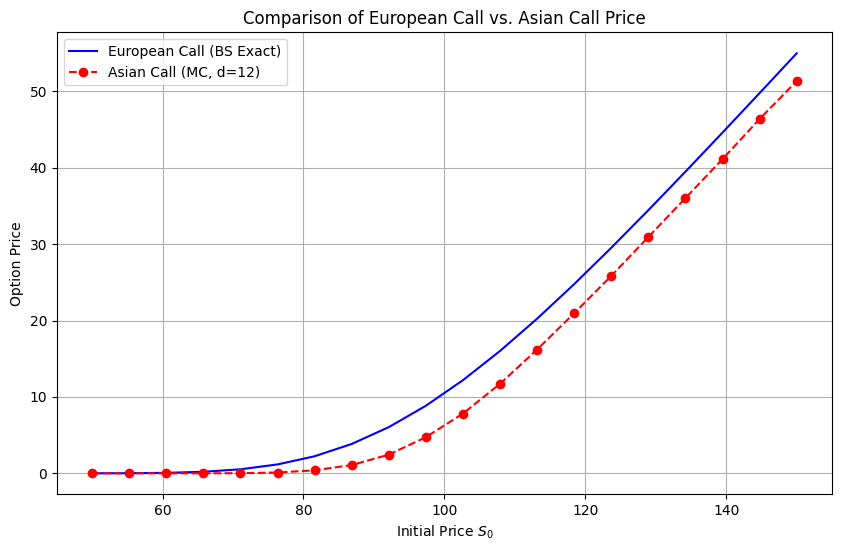

In [3]:
# Execution and Plotting
S0_range = np.linspace(50, 150, 20)  # S0 variation
asian_prices = []
euro_prices = []

# Price calculation (this may take a few seconds given N=10^5)
print(f"Calculating for {len(S0_range)} points with N={N} simulations...")

for S in S0_range:
    # European Price
    euro_prices.append(bs_call_price(S, K, T, r, sigma))

    # Asian Monte Carlo Price
    p_asian = asian_call_mc(S, K, T, r, sigma, d, N)
    asian_prices.append(p_asian)

# Graph
plt.figure(figsize=(10, 6))
plt.plot(S0_range, euro_prices, 'b-', label='European Call (BS Exact)')
plt.plot(S0_range, asian_prices, 'r--o', label=f'Asian Call (MC, d={d})')

plt.title("Comparison of European Call vs. Asian Call Price")
plt.xlabel("Initial Price $S_0$")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

We clearly observe that the Asian option price is lower than the European option price because the volatility of the average of a process is lower than the volatility of the process itself. Since the option price increases with volatility.

Both curves are increasing and correspond to a "smoothing" of the function $$(S-K)_+$$

### 2. We plot the Monte Carlo price of the Asian option and the associated confidence interval as a function of the number of observation dates d.

Confidence interval for the call price $C_n$ : $$IC_{90\%} = \left[ C_n - q_{90\%} \frac{\hat{\sigma}}{\sqrt{n}} \; ; \; C_n + q_{90\%} \frac{\hat{\sigma}}{\sqrt{n}} \right]$$

In [4]:
from scipy.stats import norm

In [5]:
S0 = 100 #fixed here
alpha = 0.01 #confidence level
d_values = list(range(1, 52))

mc_means = []
mc_cis = [] # Half-widths of confidence intervals

for d in d_values:
    dt = T / d

    # Vectorized simulation (N x d)
    Z = np.random.randn(N, d)
    growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    paths = S0 * np.cumprod(growth_factors, axis=1)

    # Calculate the arithmetic mean per path
    average_prices = np.mean(paths, axis=1)

    # Discounted payoffs
    payoffs = np.exp(-r * T) * np.maximum(average_prices - K, 0)

    # Statistics
    mean_price = np.mean(payoffs)
    std_error = np.std(payoffs) / np.sqrt(N)

    mc_means.append(mean_price)
    quantile = norm.ppf(1 - alpha/2)
    mc_cis.append(quantile * std_error)

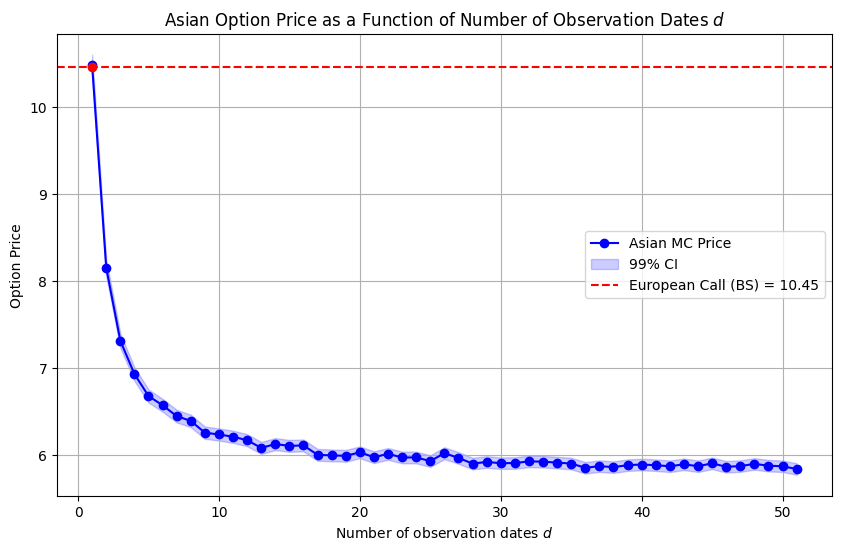

In [6]:
# --- Graph ---
plt.figure(figsize=(10, 6))

d_arr = np.array(d_values)
means_arr = np.array(mc_means)
cis_arr = np.array(mc_cis)

# Plot price and confidence envelope
plt.plot(d_arr, means_arr, 'b-o', label='Asian MC Price')
plt.fill_between(d_arr, means_arr - cis_arr, means_arr + cis_arr, color='blue', alpha=0.2, label='99% CI')

# Add theoretical European price for comparison (d=1)
# (Assuming bs_call_price function is defined in your notebook as in the previous question)
if 'bs_call_price' in locals():
    euro_price = bs_call_price(S0, K, T, r, sigma)
    plt.axhline(euro_price, color='red', linestyle='--', label=f'European Call (BS) = {euro_price:.2f}')
    # Small red dot at d=1 to show theoretical correspondence
    plt.plot(1, euro_price, 'ro')

plt.title("Asian Option Price as a Function of Number of Observation Dates $d$")
plt.xlabel("Number of observation dates $d$")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

We observe that for d=1, the Asian and European call prices are equal. Furthermore, the Asian call price becomes lower than the European price and seems to converge when d becomes very large.

### 3. We calculate the Asian option price with the control variate Z=ST​ and the value of E[Z]. We verify that the Monte Carlo price with the control variate is correct.

$Z = S_T$ so $E^Q[S_T] = S_0 e^{rT}$ in the Black & Scholes model with Q being the risk-neutral equivalent martingale measure.

We construct a new unbiased estimator with lower variance:
$\hat{C_{c^*, n}}= \frac{1}{n} \sum_{1}^{n} (C_{Asian} + c^* (S_T - S_0 e^{rT}))$ (the empirical estimator of the controlled variable)

The optimal coefficient c∗ that minimizes the variance is given by: $$c^* = -\frac{\text{Cov}(Payoff, Z')}{\text{Var}(Z')}$$



In [7]:
# Confidence parameter
confidence_level = 0.95

# Monte Carlo Simulation
dt = T / d

# Trajectory generation
Z_mat = np.random.randn(N, d)
# Growth factors between each date
growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_mat)
# Cumulative trajectories: S_t1, S_t2, ..., S_td
paths = S0 * np.cumprod(growth_factors, axis=1)

# Discounted Asian Payoff
asian_average = np.mean(paths, axis=1)
Y = np.exp(-r * T) * np.maximum(asian_average - K, 0)

# Z: Control Variate
Z = paths[:, -1]

# Theoretical expectation of Z, under Black-Scholes: E[S_T] = S0 * exp(rT)
mean_Z_theoretical = S0 * np.exp(r * T)

# Calculation of the optimal coefficient c*
cov_matrix = np.cov(Y, Z)
cov_YZ = cov_matrix[0, 1]
var_Z = cov_matrix[1, 1]

c_star = - cov_YZ / var_Z

# Controlled Estimator
Y_control = Y + c_star * (Z - mean_Z_theoretical)

# Statistical Calculations and CI
def get_stats(data, conf=0.95):
    mean_val = np.mean(data)
    var_val = np.var(data)
    n = len(data)

    # Quantile
    alpha = 1 - conf
    quantile = norm.ppf(1 - alpha/2)

    # Half-width CI
    margin = quantile * np.sqrt(var_val / n)
    return mean_val, margin, var_val

mu_std, width_std, var_std = get_stats(Y, confidence_level)
mu_ctrl, width_ctrl, var_ctrl = get_stats(Y_control, confidence_level)

# Factors
reduction_factor = var_std / var_ctrl
rho = cov_YZ / (np.std(Y) * np.std(Z))
# theo_reduction = 1 / (1 - rho**2) # This line is commented out in the original, keep it so.

print(f"--- Control Variate Z = S_T ---")
print(f"Theoretical Expectation E[S_T] : {mean_Z_theoretical:.4f}")
print(f"Empirical Expectation E[S_T] : {np.mean(Z):.4f}")
print("-" * 40)
print(f"Standard MC Price         : {mu_std:.4f} +/- {width_std:.4f}")
print(f"Controlled MC Price         : {mu_ctrl:.4f} +/- {width_ctrl:.4f}")
print("-" * 40)
print(f"Optimal coefficient c* : {c_star:.5f}")
print(f"Standard Variance        : {var_std:.6f}")
print(f"Controlled Variance       : {var_ctrl:.6f}")
print(f"Reduction Factor (Sim)  : {reduction_factor:.2f}")
print(f"Correlation (Y, S_T)     : {rho:.4f}")

--- Control Variate Z = S_T ---
Theoretical Expectation E[S_T] : 105.1271
Empirical Expectation E[S_T] : 105.2260
----------------------------------------
Standard MC Price         : 5.8586 +/- 0.0505
Controlled MC Price         : 5.8281 +/- 0.0298
----------------------------------------
Optimal coefficient c* : -0.30832
Standard Variance        : 66.323606
Controlled Variance       : 23.127452
Reduction Factor (Sim)  : 2.87
Correlation (Y, S_T)     : 0.8070


We have divided the variance by approximately 2.83 by controlling with Z. This ensures better precision for an equivalent number of samples.

### 4. Same thing with $Z_1 = \frac{1}{d} \sum S_{t_i}$​​ then $Z_2 = e^{-rT}(S_T - K)_+$​

Control Variate $Z_1 = \frac{1}{d} \sum S_{t_i}$ (Arithmetic Mean)

Control Variate $Z_2 = e^{-rT}(S_T - K)_+$ (European Call)

In [8]:
# Confidence parameter
confidence_level = 0.95

# Monte Carlo Simulation (Common)
np.random.seed(42)
Z_mat = np.random.randn(N, d)
growth_factors = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_mat)
paths = S0 * np.cumprod(growth_factors, axis=1)

# Target payoff Y (Discounted Asian)
asian_avg = np.mean(paths, axis=1)
Y = np.exp(-r * T) * np.maximum(asian_avg - K, 0)

# Utility function for control
def apply_control_variate(Y_target, Z_control, mean_Z_exact, label):
    # Covariance
    cov_matrix = np.cov(Y_target, Z_control)
    cov_YZ = cov_matrix[0, 1]
    var_Z = cov_matrix[1, 1]

    # Optimal coefficient
    c_star = cov_YZ / var_Z # Careful with the sign: Y_corr = Y - c*(Z - E[Z])

    # Correction
    Y_corrected = Y_target - c_star * (Z_control - mean_Z_exact)

    # Stats
    var_Y = np.var(Y_target)
    var_Y_c = np.var(Y_corrected)
    reduction = var_Y / var_Y_c
    rho = cov_YZ / (np.std(Y_target) * np.std(Z_control))

    # CI
    alpha = 1 - confidence_level
    q = norm.ppf(1 - alpha/2)
    margin = q * np.sqrt(var_Y_c / len(Y_target))
    mean_val = np.mean(Y_corrected)

    print(f"--- Control Variate : {label} ---")
    print(f"Estimated Price : {mean_val:.4f} +/- {margin:.4f}")
    print(f"Original Variance: {var_Y:.6f} -> Controlled: {var_Y_c:.6f}")
    print(f"Reduction Factor : {reduction:.2f}")
    print(f"Correlation : {rho:.4f}\n")
    return Y_corrected

# --- Case 1 : Z = Arithmetic Mean of prices  ---
Z1 = asian_avg

# Calculate theoretical expectation of the mean
ti_values = np.linspace(dt, T, d) # t1, t2, ..., T
mean_Z1_theoretical = np.mean(S0 * np.exp(r * ti_values))

apply_control_variate(Y, Z1, mean_Z1_theoretical, "Arithmetic Mean (Sum S_ti / d)")

# --- Case 2 : Z = European Call Payoff ---
ST = paths[:, -1]
Z2 = np.exp(-r * T) * np.maximum(ST - K, 0)

# Theoretical expectation = Black-Scholes Price
def bs_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

mean_Z2_theoretical = bs_price(S0, K, T, r, sigma)

apply_control_variate(Y, Z2, mean_Z2_theoretical, "European Call (BS Price)")

--- Control Variate : Arithmetic Mean (Sum S_ti / d) ---
Estimated Price : 5.8286 +/- 0.0204
Original Variance: 65.472475 -> Controlled: 10.875176
Reduction Factor : 6.02
Correlation : 0.9132

--- Control Variate : European Call (BS Price) ---
Estimated Price : 5.8688 +/- 0.0269
Original Variance: 65.472475 -> Controlled: 18.880764
Reduction Factor : 3.47
Correlation : 0.8436



array([ 4.86126319, 10.1396455 ,  8.99013567, ...,  1.57888026,
        6.65210554,  3.78461853])

We observe that choosing the arithmetic mean as the control variate leads to a greater variance reduction (divided by 6.02) than choosing the European call or the underlying asset price at maturity.

We could have found this result theoretically because the arithmetic mean of underlying prices is the most correlated with the Asian call price.

The variance reduction factor is $ \frac{1}{1 - \rho^2}$

### 5. Same thing with the three variables simultaneously.

In [9]:
# Confidence parameter
confidence_level = 0.95

# Monte Carlo Simulation
Z_mat = np.random.randn(N, d)
growth = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_mat)
paths = S0 * np.cumprod(growth, axis=1)

# Target payoff
asian_avg = np.mean(paths, axis=1)
Y = np.exp(-r * T) * np.maximum(asian_avg - K, 0)

# Control Variates
# Z1: S_T
Z1 = np.exp(-r * T) * paths[:, -1]
mu_Z1 = S0

# Z2: Discounted Arithmetic Mean
ti = np.linspace(dt, T, d)
mean_Z2_theo = np.exp(-r * T) * np.mean(S0 * np.exp(r * ti))
Z2 = np.exp(-r * T) * asian_avg

# Z3: European Call Payoff
def bs_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

mu_Z3 = bs_price(S0, K, T, r, sigma)
Z3 = np.exp(-r * T) * np.maximum(paths[:, -1] - K, 0)

# Multivariate Calculation
Z_matrix = np.column_stack([Z1, Z2, Z3])
mu_Z_vector = np.array([mu_Z1, mean_Z2_theo, mu_Z3])
Z_centered = Z_matrix - mu_Z_vector

# Global Covariance Matrix (4x4 : Y and the 3 Zs)
data = np.column_stack([Y, Z1, Z2, Z3])
cov_mat = np.cov(data, rowvar=False)

# Extract blocks
# Sigma_Z (3x3) : Covariance between controls (indices 1,2,3)
Sigma_Z = cov_mat[1:, 1:]
# Sigma_ZY (3,) : Covariance between Y and controls (row 0, columns 1,2,3)
Sigma_ZY = cov_mat[0, 1:]

# Calculate optimal coefficients (linear solver)
c_star = np.linalg.solve(Sigma_Z, Sigma_ZY)

# Correction
# Y_corr = Y - (c1*Z1_c + c2*Z2_c + c3*Z3_c)
correction = np.dot(Z_centered, c_star)
Y_control = Y - correction

# Results
var_std = np.var(Y)
var_ctrl = np.var(Y_control)
reduction = var_std / var_ctrl

# CI
q = norm.ppf(1 - (1 - confidence_level)/2)
margin_std = q * np.sqrt(var_std / N)
margin_ctrl = q * np.sqrt(var_ctrl / N)

print(f"--- Multiple Control (Z1, Z2, Z3) ---")
print(f"Optimal coefficients : {c_star}")
print(f"Standard Price : {np.mean(Y):.4f} +/- {margin_std:.4f}")
print(f"Controlled Price : {np.mean(Y_control):.4f} +/- {margin_ctrl:.4f}")
print(f"Reduction Factor : {reduction:.2f}")

--- Multiple Control (Z1, Z2, Z3) ---
Optimal coefficients : [-0.28546726  0.64460253  0.42596333]
Standard Price : 5.8396 +/- 0.0501
Controlled Price : 5.8571 +/- 0.0143
Reduction Factor : 12.31
